In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.5.1 True
12.4
NVIDIA A40


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
def ou_process_1d(theta=1, mu=0, sigma=1, X0=0, n_steps=10000, n_eval=200, h=1e-5):
    """
    Simulates the Ornstein-Uhlenbeck process.
    
    Parameters:
    - theta: rate of mean reversion
    - mu: long-term mean of the process
    - sigma: volatility
    - X0: initial value
    - n_steps: number of steps in each evaluation
    - n_eval: number of evaluations
    - h: Integration step size
    
    Returns:
    - A numpy array containing the simulated values at each evaluation
    """
    X_eval = np.zeros(n_eval)
    X = X0
    
    for i in range(n_eval):
        for _ in range(n_steps):
            dW = np.sqrt(h) * np.random.randn()
            X = X + theta * (mu - X) * h + sigma * dW
        X_eval[i] = X
    
    return X_eval

## Setup the parameters
theta = 1
mu = 0
sigma = 0.1

In [4]:
# Generate m initial points from the domain space [-2, 2]
m = 10
n_eval = 200
n_steps = 1000
h = 1e-4
lag_time = n_steps * h
print("lag time: ", lag_time)
X0_values = np.linspace(-2, 2, m)

# Initialize the data_matrix
data_matrix = np.zeros((m, n_eval+1, 1))

# Simulate trajectories for each initial point and store them in the data_matrix
for i, X0 in tqdm(enumerate(X0_values), total=m, desc="Simulating trajectories"):
    X_eval = np.concatenate(([X0], ou_process_1d(X0=X0, n_steps=n_steps, n_eval=n_eval, h=h)))
    data_matrix[i, :, 0] = X_eval

# Print the shape of data_matrix
print("Shape of data_matrix:", data_matrix.shape)

# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

lag time:  0.1


Simulating trajectories: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

Shape of data_matrix: (10, 201, 1)
Shape of data_X: (10, 200, 1)
Shape of data_Y: (10, 200, 1)
Shape of X: (2000, 1)
Shape of Y: (2000, 1)
(1400, 1)


In [5]:
checkpoint_file= 'ou1d_example_ckpt002.torch'

from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch

basis_function = KoopmanNNTorch(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch', a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32, delta_t= lag_time)

data_x_train_tensor = torch.DoubleTensor(data_x_train).to (device)#, requieres_grad= True)#, dtype=tf.float64)
data_y_train_tensor = torch.DoubleTensor(data_y_train).to (device)#, requires_grad= True)#, dtype=tf.float64)

In [6]:
solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

Epoch: 1 	Training Loss: 0.530494 val loss: 0.434866
saving, val loss enhanced: 0.4348659494204099 10000
Epoch: 2 	Training Loss: 0.527922 val loss: 0.433031
saving, val loss enhanced: 0.43303146281993626 0.4348659494204099
Epoch: 3 	Training Loss: 0.522442 val loss: 0.424720
saving, val loss enhanced: 0.4247200089742165 0.43303146281993626
Epoch: 4 	Training Loss: 0.515839 val loss: 0.427218
Epoch: 5 	Training Loss: 0.510226 val loss: 0.421682
saving, val loss enhanced: 0.42168170058850446 0.4247200089742165
Epoch: 6 	Training Loss: 0.506976 val loss: 0.419170
saving, val loss enhanced: 0.41917023620034266 0.42168170058850446
Epoch: 7 	Training Loss: 0.502175 val loss: 0.415264
saving, val loss enhanced: 0.4152639937278565 0.41917023620034266
Epoch: 8 	Training Loss: 0.496977 val loss: 0.409534
saving, val loss enhanced: 0.40953377351056086 0.4152639937278565
Epoch: 9 	Training Loss: 0.492660 val loss: 0.408443
saving, val loss enhanced: 0.40844316918723056 0.40953377351056086
Epoch: 

Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7519.64iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_ou.jbl
Outer Epoch 1/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7913.99iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 892.228212 val loss: 883.633158
saving, val loss enhanced: 883.6331583388678 1000000000000000.0
Epoch: 2 	Training Loss: 888.403429 val loss: 879.845762
saving, val loss enhanced: 879.8457616464041 883.6331583388678


/workspace/solver_edmd_torch_gpu_sde.py:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch: 3 	Training Loss: 884.617799 val loss: 876.078223
saving, val loss enhanced: 876.0782229324723 879.8457616464041
Epoch: 4 	Training Loss: 880.852226 val loss: 872.329031
saving, val loss enhanced: 872.3290311116476 876.0782229324723
Epoch 1 time: 9.22 seconds
Outer Epoch 2/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9946.54iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 726.463405 val loss: 719.400964
saving, val loss enhanced: 719.4009642461161 872.3290311116476
Epoch: 2 	Training Loss: 723.539210 val loss: 716.546967
saving, val loss enhanced: 716.5469674052756 719.4009642461161
Epoch: 3 	Training Loss: 720.705543 val loss: 713.746446
saving, val loss enhanced: 713.7464462674936 716.5469674052756
Epoch: 4 	Training Loss: 717.911029 val loss: 710.967254
saving, val loss enhanced: 710.967254417864 713.7464462674936
Epoch 2 time: 6.86 seconds
Outer Epoch 3/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8376.30iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 616.143152 val loss: 610.151707
saving, val loss enhanced: 610.1517067672172 710.967254417864
Epoch: 2 	Training Loss: 613.874495 val loss: 607.934762
saving, val loss enhanced: 607.9347623313985 610.1517067672172
Epoch: 3 	Training Loss: 611.671406 val loss: 605.755551
saving, val loss enhanced: 605.7555513344947 607.9347623313985
Epoch: 4 	Training Loss: 609.494814 val loss: 603.588671
saving, val loss enhanced: 603.588670829682 605.7555513344947
Epoch 3 time: 7.61 seconds
Outer Epoch 4/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9023.45iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 539.804662 val loss: 534.547321
saving, val loss enhanced: 534.5473207978662 603.588670829682
Epoch: 2 	Training Loss: 537.960087 val loss: 532.737669
saving, val loss enhanced: 532.7376687808444 534.5473207978662
Epoch: 3 	Training Loss: 536.158264 val loss: 530.951664
saving, val loss enhanced: 530.9516644622387 532.7376687808444
Epoch: 4 	Training Loss: 534.372338 val loss: 529.171767
saving, val loss enhanced: 529.1717673925655 530.9516644622387
Epoch 4 time: 7.41 seconds
Outer Epoch 5/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8659.58iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 483.637950 val loss: 478.909030
saving, val loss enhanced: 478.90902953011584 529.1717673925655
Epoch: 2 	Training Loss: 482.076510 val loss: 477.372400
saving, val loss enhanced: 477.37240027649193 478.90902953011584
Epoch: 3 	Training Loss: 480.544286 val loss: 475.851425
saving, val loss enhanced: 475.85142489878706 477.37240027649193
Epoch: 4 	Training Loss: 479.022200 val loss: 474.333616
saving, val loss enhanced: 474.3336159968432 475.85142489878706
Epoch 5 time: 7.78 seconds
Outer Epoch 6/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8725.46iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 440.215944 val loss: 435.890589
saving, val loss enhanced: 435.8905888218405 474.3336159968432
Epoch: 2 	Training Loss: 438.855932 val loss: 434.549312
saving, val loss enhanced: 434.549311550895 435.8905888218405
Epoch: 3 	Training Loss: 437.517142 val loss: 433.219156
saving, val loss enhanced: 433.2191555131808 434.549311550895
Epoch: 4 	Training Loss: 436.185358 val loss: 431.890797
saving, val loss enhanced: 431.8907968320567 433.2191555131808
Epoch 6 time: 6.89 seconds


/workspace/solver_edmd_torch_gpu_sde.py:684: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


In [7]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Koopman_matrix_K = solver.K
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict,
    'K': Koopman_matrix_K
    }

[-4.06917319e-05+0.j -1.26671999e+00+0.j -2.31104501e+00+0.j
 -3.67749417e+00+0.j]


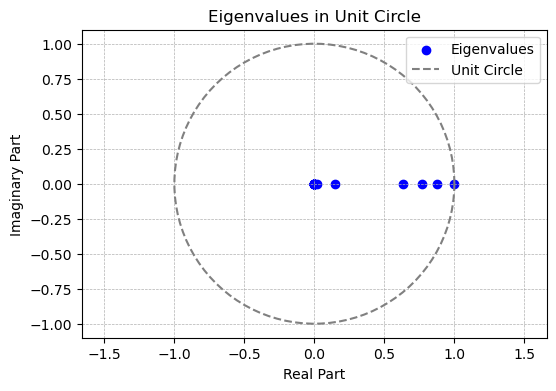

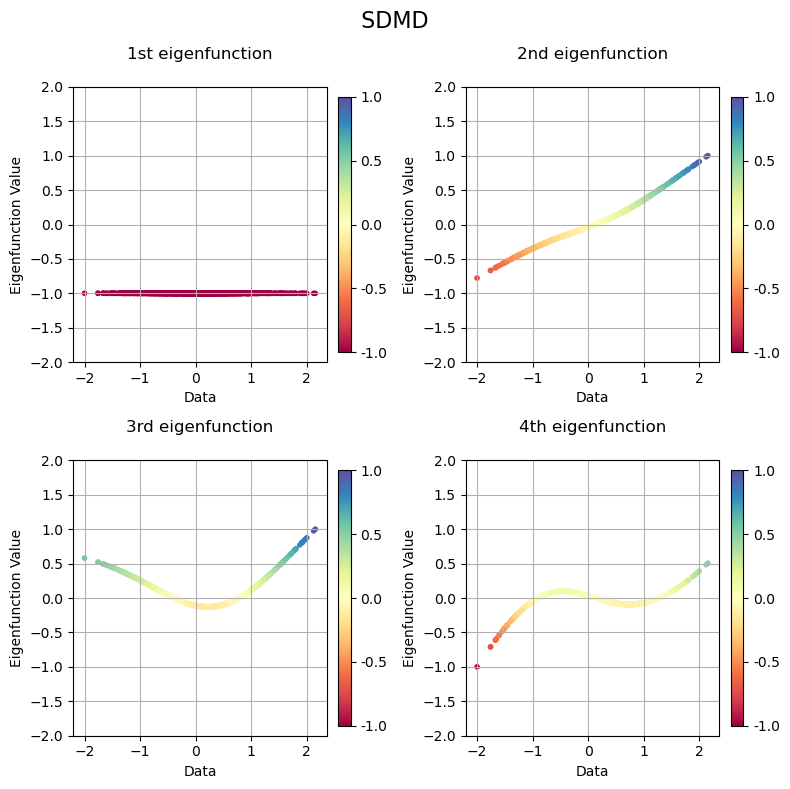

In [8]:
# Take ln values of the eigenvalues and divide by 0.1
# ln_evalues = np.log(evalues[:4]) / lag_time
ln_evalues = (evalues[:4]-1) / lag_time

print(ln_evalues)

## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' SDMD ', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
basis_function_g = KoopmanNNTorch_g(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver_g = KoopmanSolverTorch_g(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch',  a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32)

In [10]:
solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=32,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8,   
    )

Precomputed SDE coefficients loaded from: a_b_example_ou.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9606.03iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Outer Epoch 1/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9118.80iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9252.47iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9656.56iteration/s] 


Epoch: 1 	Training Loss: 0.842145 val loss: 0.828716
saving, val loss enhanced: 0.8287159073342439 1000000000000000.0
Epoch: 2 	Training Loss: 0.818797 val loss: 0.805525
saving, val loss enhanced: 0.8055249773042551 0.8287159073342439
Epoch: 3 	Training Loss: 0.795869 val loss: 0.782959
saving, val loss enhanced: 0.7829588233463711 0.8055249773042551
Epoch: 4 	Training Loss: 0.773597 val loss: 0.761048
saving, val loss enhanced: 0.7610477901743221 0.7829588233463711


/workspace/solver_gedmd_torch_gpu.py:309: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch 1 time: 16.92 seconds
Outer Epoch 2/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9962.16iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9497.71iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9475.29iteration/s]


Epoch: 1 	Training Loss: 0.663040 val loss: 0.656720
saving, val loss enhanced: 0.6567203770348505 0.7610477901743221
Epoch: 2 	Training Loss: 0.647839 val loss: 0.641627
saving, val loss enhanced: 0.6416272958092146 0.6567203770348505
Epoch: 3 	Training Loss: 0.632826 val loss: 0.626635
saving, val loss enhanced: 0.6266352218079673 0.6416272958092146
Epoch: 4 	Training Loss: 0.617942 val loss: 0.611802
saving, val loss enhanced: 0.6118024725875432 0.6266352218079673
Epoch 2 time: 16.06 seconds
Outer Epoch 3/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9729.40iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9956.06iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8733.13iteration/s]


Epoch: 1 	Training Loss: 0.536975 val loss: 0.532136
saving, val loss enhanced: 0.5321363937120318 0.6118024725875432
Epoch: 2 	Training Loss: 0.526531 val loss: 0.521771
saving, val loss enhanced: 0.5217713673896137 0.5321363937120318
Epoch: 3 	Training Loss: 0.516182 val loss: 0.511424
saving, val loss enhanced: 0.5114236254005842 0.5217713673896137
Epoch: 4 	Training Loss: 0.505861 val loss: 0.501116
saving, val loss enhanced: 0.5011164201776782 0.5114236254005842
Epoch 3 time: 16.18 seconds
Outer Epoch 4/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9712.33iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9123.66iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8307.01iteration/s]


Epoch: 1 	Training Loss: 0.448483 val loss: 0.445717
saving, val loss enhanced: 0.44571721003964476 0.5011164201776782
Epoch: 2 	Training Loss: 0.440865 val loss: 0.438136
saving, val loss enhanced: 0.4381360218487827 0.44571721003964476
Epoch: 3 	Training Loss: 0.433299 val loss: 0.430554
saving, val loss enhanced: 0.4305538900275315 0.4381360218487827
Epoch: 4 	Training Loss: 0.425736 val loss: 0.422981
saving, val loss enhanced: 0.4229809295310991 0.4305538900275315
Epoch 4 time: 18.59 seconds
Outer Epoch 5/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8218.54iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8457.75iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8515.79iteration/s]


Epoch: 1 	Training Loss: 0.382443 val loss: 0.380604
saving, val loss enhanced: 0.38060358373055564 0.4229809295310991
Epoch: 2 	Training Loss: 0.376761 val loss: 0.374946
saving, val loss enhanced: 0.3749456063858658 0.38060358373055564
Epoch: 3 	Training Loss: 0.371110 val loss: 0.369278
saving, val loss enhanced: 0.36927849182909567 0.3749456063858658
Epoch: 4 	Training Loss: 0.365453 val loss: 0.363607
saving, val loss enhanced: 0.36360711662387446 0.36927849182909567
Epoch 5 time: 20.51 seconds
Outer Epoch 6/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9360.37iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9947.13iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8764.44iteration/s]


Epoch: 1 	Training Loss: 0.333170 val loss: 0.332168
saving, val loss enhanced: 0.3321675177507834 0.36360711662387446
Epoch: 2 	Training Loss: 0.328801 val loss: 0.327809
saving, val loss enhanced: 0.3278092006755308 0.3321675177507834
Epoch: 3 	Training Loss: 0.324449 val loss: 0.323440
saving, val loss enhanced: 0.3234403068333463 0.3278092006755308


/workspace/solver_gedmd_torch_gpu.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


Epoch: 4 	Training Loss: 0.320087 val loss: 0.319063
saving, val loss enhanced: 0.31906337386767264 0.3234403068333463
Epoch 6 time: 18.89 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9105.47iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0


In [11]:
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict
    }

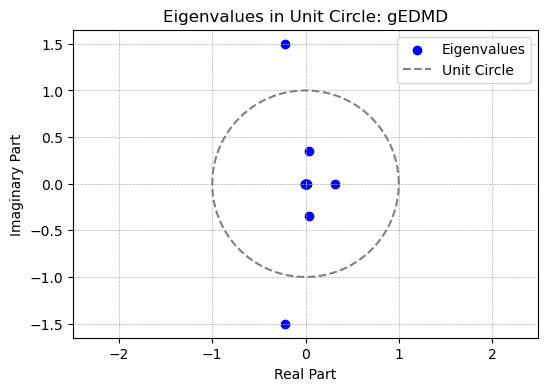

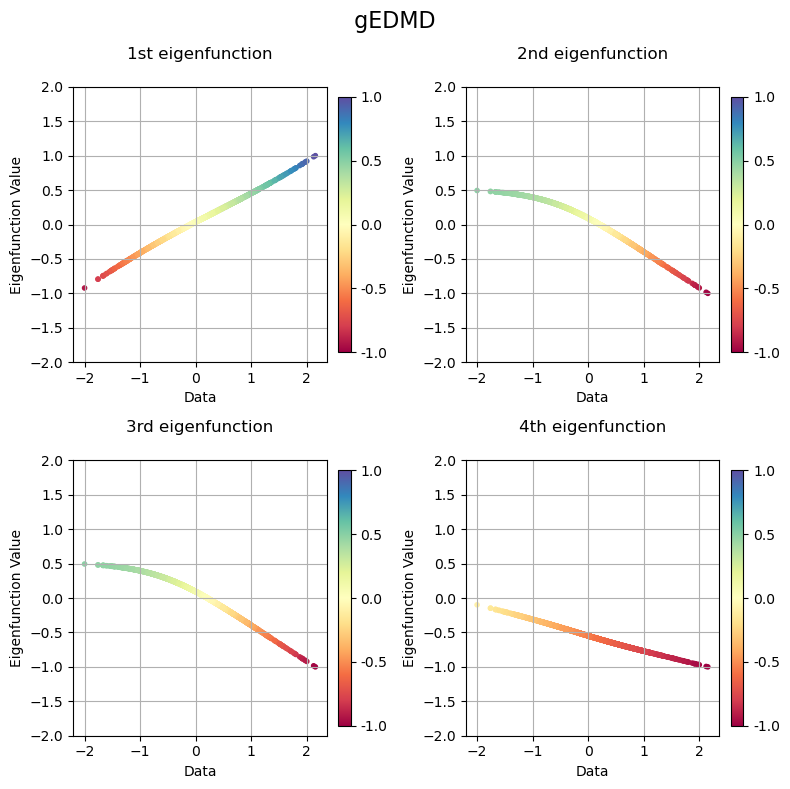

In [12]:
## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()